<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a>&nbsp;| [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en) | <a href="https://supaerodatascience.github.io/machine-learning/">https://supaerodatascience.github.io/machine-learning/</a>

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">XGBoost<br>Introduction to XGBoost</div>

This Practice Course is composed of 3 parts - each part is meant to be done in about 1 hour :
* In the **first notebook**, you learned the **basic of XGBoost**, how to apply it on a dataset and tune it to obtain the best performances.
* In the **second notebook**, we will focus on **ensemble methods** and explain what makes XGBoost different from other models.
* Finally in the **last notebook** you will see how the choice of a method (such as XGBoost) is a key element of a tradeoff between **Bias and Variance**. 

# About Ensemble methods

Ensemble method are based on the hypothesis that combining multiple models together can often produce a much more powerful model.

The goal of this notebook is to understand and manipulate the model behind XGBoost, to better understand the various parameters related to this model.
We will have 3 exercices :
* A short exercice focused on Weak Learners
* Then we will see the difference between Boosting vs Bagging vs stacking
* A specific focus on Ensemble Trees, where you will learn to tune the parameters of XGBoost that are specific to trees.

# Weak learners

**Weak learners** are basic models that do not perform so well by themselves, either because they have a high bias (low degree of freedom models, for example) or because they have too much variance to be robust (high degree of freedom models, for example). The idea of ensemble methods is to try reducing bias and/or variance of such weak learners by combining several of them together in order to create a strong learner (or ensemble model) that achieves better performances.

In the following exemple, we will use a "decision stumps." A decision stump is simply a decision tree where the whole tree is just one node. 


<div class="alert alert-success">
    <b>Exercice 1</b><br>
      Based on the following code, produce a weak learner on the given dataset.
      <br>
      Subsidiary question : what can be parallelized in the following code ?
</div>

In [4]:
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 

class Stump:
    def __init__(self):
        self.gtLabel = None
        self.ltLabel = None
        self.splitThreshold = None
        self.splitFeature = None

    def predict(self, listpoint):
        return np.array([self.predict_single(x) for x in listpoint])
        
    def predict_single(self, point):
        if point[self.splitFeature] >= self.splitThreshold:
            return self.gtLabel
        else:
            return self.ltLabel

    def __call__(self, point):
        return self.predict(point)

    def errorFunction(self, data,index, t):
        left_side = sum([1.0 for x,y in data if self.makeThreshold(x, t, index) != y]) / len(data)
        right_side = 1. - left_side
        return min(left_side, right_side)


    def makeThreshold(self,x, t,index):
        return  1 if x[index] <= t else 0

    def bestThreshold(self,data, index):
        '''Compute best threshold for a given feature. Returns (threshold, error)'''

        thresholds = [x[index] for x,y in data]
        errors = [(threshold, self.errorFunction(data, index, threshold)) for threshold in thresholds]
        return min(errors, key=lambda p: p[1])


    def majorityVote(self,labels):
        try:
            return max(set(labels), key=labels.count)
        except:
            return 0

    def fit(self,X, Y):
        data = list(zip(X,Y))
        # find the index of the best feature to split on, and the best threshold for that index.

        bestThresholds = [(i,) + self.bestThreshold(data, i) for i in range(len(X[0]))]
        feature, thresh, _ = min(bestThresholds, key = lambda p: p[2])

        self.splitFeature = feature
        self.splitThreshold = thresh
        self.gtLabel = self.majorityVote([y for x,y in data if x[self.splitFeature] >= self.splitThreshold])
        self.ltLabel = self.majorityVote([y for x,y in data if x[self.splitFeature] < self.splitThreshold])




In [6]:
breast = datasets.load_breast_cancer()
#print(breast.DESCR)

X_train, X_test, y_train, y_test = train_test_split(breast.data, breast.target, test_size=0.2, random_state=42)

stump = Stump()
stump.fit(X_train,y_train)
print(accuracy_score(y_train, stump.predict(X_train)))
print(accuracy_score(y_test, stump.predict(X_test)))

0.9186813186813186
0.8859649122807017


In [7]:
# you can use this code as a comparison point
tree = DecisionTreeClassifier(max_depth=1, random_state=0)
tree.fit(X_train,y_train)
print(accuracy_score(y_test, tree.predict(X_test)))


n_nodes = tree.tree_.node_count
children_left = tree.tree_.children_left
children_right = tree.tree_.children_right
feature = tree.tree_.feature
threshold = tree.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))

0.8947368421052632
The binary tree structure has 3 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 7] <= 0.05127999931573868 else to node 2.
	node=1 leaf node.
	node=2 leaf node.




# Boosting vs Bagging vs stacking
The main hypothesis is that when weak models are correctly combined we can obtain more accurate and/or robust models.

* **Bagging** considers homogeneous weak learners, learns them independently from each other in parallel and combines them following some kind of deterministic averaging process
* **Boosting** considers homogeneous weak learners, learns them sequentially in a very adaptative way (a base model depends on the previous ones) and combines them following a deterministic strategy
* **Stacking** considers heterogeneous weak learners, learns them in parallel and combines them by training a meta-model to output a prediction based on the different weak models predictions


<div class="alert alert-success">
    <b>Question 2</b><br>
      Which kind is XGBoost ? Which kind is Random Forest ?
</div>

Each of these technics aims at improving either the *bias* or the *variance* of the individual weak learners.
<img src="img/1 5pA6iY-qDP2JIsLoyfje-Q@2x.png">

## Focus on Boosting
The intuition behind boosting is that each new model focus its efforts on the most difficult observations to fit up to now, so that we obtain, at the end of the process, a strong learner with lower bias. Boosting is a gerneral technic that is used with success by the the [top solutions](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629#250927) in Kaggle competition - it is a crucial competence to master by going beyond using black-box library.

Being mainly focused at reducing bias, the base models that are often considered for boosting are models with low variance but high bias. For instance, if we want to use trees as our base models, we will choose most of the time shallow decision trees with only a few depths.

There are two emblematic Boosting algorithms : **Adaboost** and **Gradient Boosting**. Since Gradient Boosting is the algorithm used in XGboost, we will try to understand how it works.

Here are the steps of a simpler version of Gradient Boosting :
* 1 - Fit a simple  decision tree on data
* 2 - Calculate error residuals. Actual target value, minus predicted target value
* 3 - Fit a new model on error residuals as target variable with same input variables
* 4 - Add the predicted residuals to the previous predictions
* 5 - Fit another model on residuals that is still left. Repeat steps 2 to 5 until overfitting or the sum of residuals becomes constant



<div class="alert alert-success">
    <b>Exercice 3</b><br>
      Use the following code to improve the weak learner by one step of boosting. Consider it as a regression problem and use directly DecisionTreeRegressor as the stump. Evaluate the result with the mean_squared_error function
</div>

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

stump = DecisionTreeRegressor(max_depth = 1)
stump.fit(X_train, y_train)
prediction = stump.predict(X_train)

# Calculate initial performance
train_mse = mean_squared_error(y_train, prediction)
test_mse = mean_squared_error(y_test, stump.predict(X_test))

print("Training R^2:", 1 - train_mse)
print("Testing R^2:", 1 - test_mse)
print()

# Boosting step
# Calculate the residuals
residuals = y_train - prediction

# Fit the stump to the residuals
stump_residuals = DecisionTreeRegressor(max_depth=1)
stump_residuals.fit(X_train, residuals)

# Update predictions
prediction_updated = prediction + stump_residuals.predict(X_train)

# Calculate updated performance on the training set
updated_train_mse = mean_squared_error(y_train, prediction_updated)

# Calculate updated predictions for the test set
test_predictions = stump.predict(X_test) + stump_residuals.predict(X_test)

# Calculate updated performance on the test set
updated_test_mse = mean_squared_error(y_test, test_predictions)

print("Updated Training R^2:", 1 - updated_train_mse)
print("Updated Testing R^2:", 1 - updated_test_mse)

Training R^2: 0.927955912410469
Testing R^2: 0.9075418866668075

Updated Training R^2: 0.9396295700851687
Updated Testing R^2: 0.9229730654883681


# Ensemble Tree
XGBoost use Trees as the Weak Learners in the Gradient Boosting algorithm. A nice overview can be found on the [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html).

In XGBoost we can draw the constructed tree after fitting with the following code :

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline


from xgboost import XGBClassifier
import xgboost as xgb

iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth': 3,  'eta': 0.3, 'objective': 'multi:softprob', 'num_class': 3}
num_round = 20 

bst = xgb.train(param, dtrain, num_round)

bst.dump_model('dump.raw.txt') # dump for model explanation

with open('dump.raw.txt', 'r') as file:
    data = file.read()
    print (data)

booster[0]:
0:[f2<3] yes=1,no=2,missing=2
	1:leaf=0.426035523
	2:leaf=-0.218845025
booster[1]:
0:[f2<3] yes=1,no=2,missing=2
	1:leaf=-0.213017777
	2:[f3<1.79999995] yes=3,no=4,missing=4
		3:[f2<5] yes=5,no=6,missing=6
			5:leaf=0.409090936
			6:leaf=-9.7534878e-09
		4:[f2<4.9000001] yes=7,no=8,missing=8
			7:leaf=-7.66345476e-09
			8:leaf=-0.210218996
booster[2]:
0:[f2<4.80000019] yes=1,no=2,missing=2
	1:[f3<1.5] yes=3,no=4,missing=4
		3:leaf=-0.217894763
		4:[f0<5.69999981] yes=7,no=8,missing=8
			7:leaf=-7.66345476e-09
			8:leaf=-0.155172437
	2:[f3<1.79999995] yes=5,no=6,missing=6
		5:[f2<5.0999999] yes=9,no=10,missing=10
			9:leaf=-0.0360000096
			10:leaf=0.179999992
		6:[f2<4.9000001] yes=11,no=12,missing=12
			11:leaf=0.128571421
			12:leaf=0.420437962
booster[3]:
0:[f2<3] yes=1,no=2,missing=2
	1:leaf=0.293278694
	2:leaf=-0.195823714
booster[4]:
0:[f2<3] yes=1,no=2,missing=2
	1:leaf=-0.189503655
	2:[f3<1.79999995] yes=3,no=4,missing=4
		3:[f2<5] yes=5,no=6,missing=6
			5:leaf=0.28

As you can see, we have the *boosting* logic of having Decision Trees one after the other, while each single Decision Tree is very shallow.

We will now focus on some parameters specific to trees. 

* n_estimators: number of trees you want to build.
* max_depth: determines how deeply each tree is allowed to grow during any boosting round.
* subsample: percentage of samples used per tree.
* gamma: minimum loss reduction required to make a further partition on a leaf node of the tree.


<div class="alert alert-success">
    <b>Exercice 4</b><br>
      Among these 4 parameters and using the following code, determine for each parameter if a low or a high value leads to Overfitting/Underfitting.
</div>


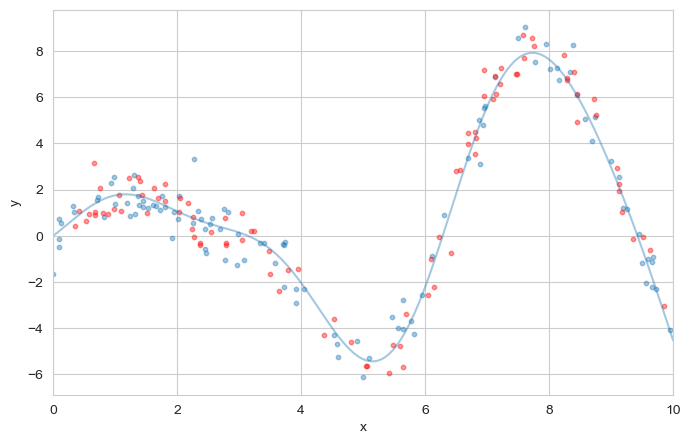

In [13]:
import numpy as np

def ground_truth(x):
    """Ground truth -- function to approximate"""
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    """generate training and testing data"""
    np.random.seed(13)
    x = np.random.uniform(0, 10, size=n_samples)
    x.sort()
    y = ground_truth(x) + 0.75 * np.random.normal(size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    x_train, y_train = x[train_mask, np.newaxis], y[train_mask]
    x_test, y_test = x[~train_mask, np.newaxis], y[~train_mask]
    return x_train, x_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_data(200)

# plot ground truth
x_plot = np.linspace(0, 10, 500)
def plot_data(figsize=(8, 5)):
    fig = plt.figure(figsize=figsize)
    gt = plt.plot(x_plot, ground_truth(x_plot), alpha=0.4, label='ground truth')

    # plot training and testing data
    plt.scatter(X_train, y_train, s=10, alpha=0.4)
    plt.scatter(X_test, y_test, s=10, alpha=0.4, color='red')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('x')
    
plot_data(figsize=(8, 5))


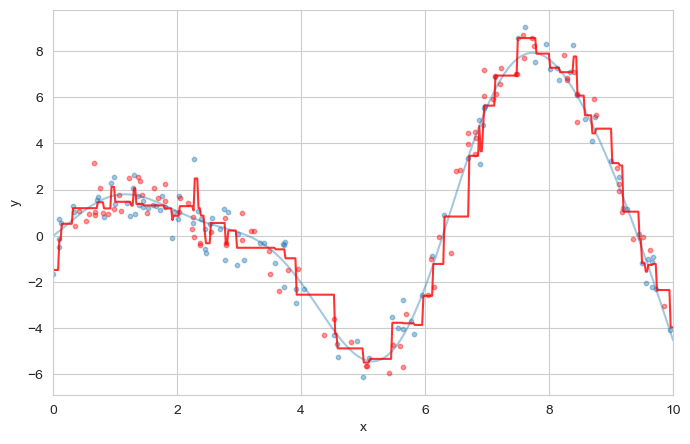

In [44]:
from itertools import islice
from xgboost import XGBRegressor

est = XGBRegressor(max_depth=2,subsample=1,gamma=0,n_estimators=100)
est.fit(X_train, y_train)

#ax = plt.gca()

# step over prediction as we added 20 more trees.
plot_data()
plt.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='r', alpha=0.8)


<div class="alert alert-warning">**Takeaway Questions**<br>
a) What is the model behind XGBoost?
<br>
b) What is the difference between a random forest and boosted trees?
<br>
</div>

<div class="alert-danger"><a href="#answers1" data-toggle="collapse">**Answers (click to unhide):**</a><br>
<div id="answers1" class="collapse">
a) Boosted trees, which are ensemble trees, i.e. a finite set of classification and regression trees. Like other ensemble methods, each tree participates in the prediction made by the model which is a sum of the outputs of all the trees.
<br>
b) Random forest and boosted trees use the same model but are trained in a different way. Random forests are trained using the technique of bootstrap aggregating, or bagging, while boosted trees are trained with gradient descent.
<br>
</div>
</div>

# Conclusion of the notebook

In the notebook, we have seen the algorithm and the model behind XGBoost. 
The next and last notebook will continue the tuning of the parameters, with regards to the tradeoff between biais and variance.

Sources :
* https://medium.com/@aravanshad/ensemble-methods-95533944783f
* https://www.datacamp.com/community/tutorials/xgboost-in-python
* https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205
* https://jeremykun.com/2015/05/18/boosting-census/
* https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d